## ✅ Step 1: Install Required Packages

Before we begin, we need to install the core dependencies for our object-detection workflow:

- **torch**: the main PyTorch library for tensor operations and GPU support  
- **torchvision**: provides datasets, data transforms, and pre-trained detection models  
- **tqdm**: a lightweight progress-bar utility for monitoring loops  


In [ ]:
# ✅ Step 1: Install Required Packages
!pip install torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## ✅ Step 2: Import Libraries

In this step, we bring in all the Python packages and modules needed for loading data, defining the model, and visualizing results:

- **torch**: Core PyTorch library for tensor operations and GPU acceleration  
- **torchvision**: Utilities for computer vision, including datasets, transforms, and pre-trained models  
- **fasterrcnn_resnet50_fpn** from `torchvision.models.detection`: Pre-trained Faster R-CNN with ResNet-50 backbone and Feature Pyramid Network  
- **VOCDetection** from `torchvision.datasets`: Pascal VOC dataset loader for object detection  
- **torchvision.transforms** (`T`): Standard image transformations for data augmentation and preprocessing  
- **torchvision.transforms.functional** (`F`): Functional API for more fine-grained image transforms  
- **GeneralizedRCNNTransform** from `torchvision.models.detection.transform`: Handles resizing, normalization, and batching for Faster R-CNN  
- **DataLoader** from `torch.utils.data`: For batching and shuffling the dataset during training  
- **os**: Operating-system interfaces for file and path operations  
- **tqdm**: Progress-bar utility to track training loops  
- **matplotlib.pyplot** (`plt`): Plotting library to display images and detection boxes  
- **random**: Utility for random sampling (e.g., picking example images)  


In [ ]:
# ✅ Step 2: Import Libraries
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import VOCDetection
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
from torchvision.models.detection.transform import GeneralizedRCNNTransform
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

## ✅ Step 3: Set Up the Dataset

Here we define a custom `VOCDataset` class to wrap the Pascal VOC loader and convert its annotations into the format expected by our detection models:

1. **Initialization**  
   - Uses `VOCDetection` to download and load the VOC dataset (year, split configurable).  
   - Accepts an optional `transforms` callable for image preprocessing.

2. **`__getitem__`**  
   - Retrieves the raw image and its annotation dict (`‘annotation’`).  
   - Iterates over each object in `annotation['object']` to extract:  
     - **Bounding boxes** (`xmin, ymin, xmax, ymax`) as a FloatTensor of shape `[N, 4]`.  
     - **Labels** mapped to integer indices via `VOC_CLASSES`.  
   - Builds an `image_id` tensor to track the sample index.  
   - Packages everything into a `target_dict` with keys:  
     - `'boxes'`: tensor of box coordinates  
     - `'labels'`: tensor of class indices  
     - `'image_id'`: tensor containing the image index  
   - Applies any provided `transforms` to the image before returning.

3. **`__len__`**  
   - Returns the total number of samples in the VOC split.

This class ensures each sample is a tuple `(image_tensor, target_dict)` ready for use by the TorchVision detection models.  


In [ ]:
# ✅ Step 3: Set Up the Dataset
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year='2007', image_set='trainval', transforms=None):
        self.dataset = VOCDetection(root, year=year, image_set=image_set, download=True)
        self.transforms = transforms

    def __getitem__(self, idx):
        img = self.dataset[idx][0]
        target = self.dataset[idx][1]['annotation']

        boxes = []
        labels = []

        for obj in target['object']:
            bbox = obj['bndbox']
            xmin = float(bbox['xmin'])
            ymin = float(bbox['ymin'])
            xmax = float(bbox['xmax'])
            ymax = float(bbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(VOC_CLASSES.index(obj['name']))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        target_dict = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target_dict

    def __len__(self):
        return len(self.dataset)

## ✅ Step 5: Define Transforms

In this step, we specify the preprocessing pipeline for our images before they are passed to the model:

- **`T.ToTensor()`**:  
  Converts a PIL image or NumPy array into a PyTorch FloatTensor of shape `[C, H, W]` and scales pixel values from `[0, 255]` to `[0.0, 1.0]`.

You can extend this pipeline with additional augmentations (e.g. random flips, normalization, color jitter) by adding more transform operations inside the `Compose` list.  


In [ ]:
# ✅ Step 5: Transforms
transform = T.Compose([
    T.ToTensor()
])

## ✅ Step 6: Load Dataset

Now we instantiate our custom VOC dataset and wrap it in a DataLoader for batching and shuffling:

- **`VOCDataset("./", transforms=transform)`**  
  Loads the Pascal VOC data from the current directory, applying the `transform` pipeline defined earlier to each image.

- **`DataLoader(...)`**  
  - **`batch_size=2`**: Processes two images per iteration.  
  - **`shuffle=True`**: Randomizes sample order each epoch for better training.  
  - **`collate_fn=lambda x: tuple(zip(*x))`**:  
    Groups a list of `(image, target)` pairs into a batch of images and a corresponding list of target dictionaries, preserving the detection API’s expected input format.  


In [ ]:
# ✅ Step 6: Load Dataset
train_dataset = VOCDataset("./", transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


100%|██████████| 460M/460M [00:29<00:00, 15.6MB/s]


## ✅ Step 7: Load Model

In this step, we prepare our detection model to work with the Pascal VOC classes:

- **Device selection**  
  ```python
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
# ✅ Step 7: Load Model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(pretrained=True)
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair",
    "cow", "diningtable", "dog", "horse",
    "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(VOC_CLASSES))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## ✅ Step 8: Training Loop

In this step, we define and run the core training loop for our detection model:

1. **Optimizer Setup**  
   ```python
   optimizer = torch.optim.SGD(
       model.parameters(),
       lr=0.005,          # learning rate
       momentum=0.9,      # momentum term for SGD
       weight_decay=0.0005  # L2 regularization
   )


In [ ]:
# ✅ Step 8: Training Loop
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 2
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

Epoch 1: 100%|██████████| 2506/2506 [24:06<00:00,  1.73it/s]


Epoch [1/2], Loss: 1066.8949


Epoch 2: 100%|██████████| 2506/2506 [24:17<00:00,  1.72it/s]

Epoch [2/2], Loss: 866.2421


## ✅ Step 9: Save Model

Once training is complete, we persist the learned weights to disk and confirm the save:

- **`torch.save(model.state_dict(), "fasterrcnn_pascalvoc.pth")`**  
  Serializes only the model’s parameters (state dictionary) to a `.pth` file.

- **`print("Model saved as fasterrcnn_pascalvoc.pth")`**  
  Prints a simple confirmation message so you know the file was written successfully.  


In [ ]:
# ✅ Step 9: Save Model
torch.save(model.state_dict(), "fasterrcnn_pascalvoc.pth")
print("Model saved as fasterrcnn_pascalvoc.pth")

Model saved as fasterrcnn_pascalvoc.pth


## ✅ Step 10: Inference on Random Sample

Now that the model is trained, we switch to evaluation mode and visualize its predictions:

1. **Set evaluation mode**  
   ```python
   model.eval()


In [ ]:
# ✅ Step 10: Inference on Random Sample
model.eval()
sample_img, _ = train_dataset[random.randint(0, len(train_dataset) - 1)]
with torch.no_grad():
    prediction = model([sample_img.to(device)])[0]

def show(img, prediction, score_threshold=0.5):
    img = F.to_pil_image(img)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()

    boxes = prediction['boxes'].detach().cpu()
    labels = prediction['labels'].detach().cpu()
    scores = prediction['scores'].detach().cpu()

    for box, label, score in zip(boxes, labels, scores):
        if score < score_threshold:
            continue
        xmin, ymin, xmax, ymax = box
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='red', linewidth=2))
        ax.text(xmin, ymin, f"{VOC_CLASSES[label]}: {score:.2f}", color='white',
                bbox=dict(facecolor='red', alpha=0.5))
    plt.axis("off")
    plt.show()


## ✅ Step 11: Visualize Ground-Truth Annotations

This cell defines and uses a helper to display the true bounding boxes and class labels (in blue) for any sample image:

- **`show_ground_truth(img, target)`**  
  - Converts the image tensor to a PIL image.  
  - Plots the image with Matplotlib.  
  - Iterates over each ground-truth box and label:  
    - Draws a **blue** rectangle (`linewidth=2`) for each box.  
    - Places the class name in a white-on-blue label at the top-left of each box.  
  - Disables axes and displays the annotated image.

- **Example usage**  
  ```python
  sample_img, sample_target = train_dataset[random.randint(0, len(train_dataset) - 1)]
  show_ground_truth(sample_img, sample_target)


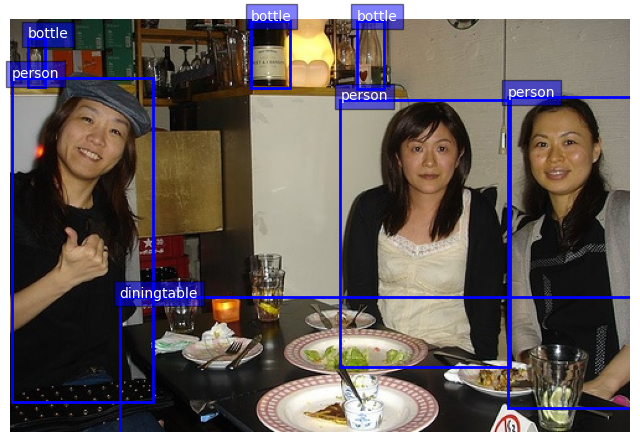

In [ ]:
def show_ground_truth(img, target):
    img = F.to_pil_image(img)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()

    boxes = target['boxes']
    labels = target['labels']

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='blue', linewidth=2))
        ax.text(xmin, ymin, VOC_CLASSES[label], color='white',
                bbox=dict(facecolor='blue', alpha=0.5))
    plt.axis("off")
    plt.show()

# Example usage
sample_img, sample_target = train_dataset[random.randint(0, len(train_dataset) - 1)]
show_ground_truth(sample_img, sample_target)
